In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson, binom

# Напишем функцию бутстрап для расчета ratio

In [12]:
def bootstrap_ratio(df, variant_col, num_col, den_col, boot_it):
    is_test = df[variant_col] == 1
    rto_0 = sum(df[num_col][df[variant_col] == 0]) / sum(df[den_col][df[variant_col] == 0])
    rto_1 = sum(df[num_col][df[variant_col] == 1]) / sum(df[den_col][df[variant_col] == 1])
    delta = abs(rto_0 - rto_1)
    count = 0
    
    for i in range(boot_it):
        booted_index = is_test.sample(len(is_test)).values
        sample_0 = sum(df.loc[True == booted_index][num_col]) / sum(df.loc[True == booted_index][den_col])
        sample_1 = sum(df.loc[False == booted_index][num_col]) / sum(df.loc[False == booted_index][den_col])

        if abs(sample_0-sample_1)>=delta:
            count += 1
    pvalue = count / boot_it
    return pvalue


In [13]:
N = 10000
n_sim = 500
alpha = 0.5
pvalue_list = []
for i in range(n_sim):
    if i % 100 == 0:
        print(i)
        
    df = pd.DataFrame({
        "variant": binom.rvs(1, 0.5, size=N), 
        "numerator": np.random.poisson(10, N),
        "denominator": np.random.poisson(5, N)
    })
    
    pvalue = bootstrap_ratio(df, "variant", "numerator", "denominator", 100)
    pvalue_list.append(pvalue)
    

0
100
200
300
400


0.51


<AxesSubplot:ylabel='Count'>

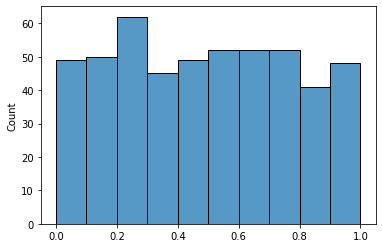

In [14]:
print(sum(np.array(pvalue_list) < alpha) / n_sim)
sns.histplot(pvalue_list)

# Напишем функцию бутстрап с применением Пуассоновской оптимизации

In [4]:
def poisson_bootstrap(num_0, den_0, num_1, den_1, n_bootstrap=2000):

    rto0 = np.array([num_0 / den_0])
    rto1 = np.array([num_1 / den_1])

    poisson_0 = poisson(1).rvs((n_bootstrap, rto0.size)).astype(np.int64)
    poisson_1 = poisson(1).rvs((n_bootstrap, rto1.size)).astype(np.int64)

    den_0 = np.array([den_0])
    den_1 = np.array([den_1])
    rto0 = np.matmul(rto0 * den_0, poisson_0.T)
    w0 = np.matmul(den_0, poisson_0.T)
    rto1 = np.matmul(rto1 * den_1, poisson_1.T)
    w1 = np.matmul(den_1, poisson_1.T)

    delta = rto1 / w1 - rto0 / w0
    positions = np.sum(delta < 0)

    pvalue = 2 * np.minimum(positions, n_bootstrap - positions) / n_bootstrap
    return pvalue

In [5]:
np.random.seed(3)
n = 20000

df = pd.DataFrame({
    'session_cnt': np.random.randint(low = 1, high = 10, size = n),
    'revenue_amt': np.random.exponential(100, size=n),
    'split': np.random.randint(low = 0, high = 2, size = n)
})

display(df)

,session_cnt,revenue_amt,split
0,9,16.563763,1
1,4,29.567273,1
2,9,100.259226,1
3,9,638.925351,1
4,1,155.445262,1
...,...,...,...
19995,4,116.250564,1
19996,9,193.035489,1
19997,2,164.304770,1
19998,7,81.138947,0


In [9]:
%%timeit -r 10
bootstrap_ratio(df[1:100], "split", "revenue_amt", "session_cnt", 2000)

1.27 s ± 5.54 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [10]:
%%timeit -r 10
poisson_bootstrap(
    df[1:100].revenue_amt[df[1:100].split == 0],
    df[1:100].session_cnt[df[1:100].split == 0],
    df[1:100].revenue_amt[df[1:100].split == 1],
    df[1:100].session_cnt[df[1:100].split == 1]
)

12.2 ms ± 60.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


Скорость на лицо